In [1]:
# import libraries needed
import pandas as pd 
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = pd.read_excel('/content/drive/My Drive/jedha fundies/Data/100k lines_Data NYC restaurants.xlsx')

In [4]:
dataset.head()

,ÔªøCAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50070206,BLUE CAFE RESTAURANT & BAR,Queens,8263,BROADWAY,11373.0,7183960717,Spanish,2018-11-01 00:00:00,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140¬∫ F.,Y,14.0,NaN,NaN,07/20/2020,Pre-permit (Operational) / Initial Inspection,40.741920,-73.881125,404.0,25.0,27100.0,4037524.0,4.015180e+09,QN29
1,41713504,ISIS RESTAURANT,Bronx,739,ALLERTON AVENUE,10467.0,7183241054,Mexican,2019-09-10 00:00:00,Establishment Closed by DOHMH. Violations wer...,08A,Facility not vermin proof. Harborage or condit...,N,40.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.865466,-73.865700,211.0,15.0,33800.0,2053637.0,2.045100e+09,BX07
2,41674628,MANHATTAN PROPER,Manhattan,6,MURRAY STREET,10007.0,6465594445,American,02/26/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,20.0,B,02/26/2019,07/20/2020,Cycle Inspection / Re-inspection,40.713222,-74.007622,101.0,1.0,2100.0,1001407.0,1.001240e+09,MN24
3,50012117,ROBERTA'S PIZZA & BAKERY,Brooklyn,261,MOORE STREET,11206.0,7184171118,Pizza,2019-01-05 00:00:00,No violations were recorded at the time of thi...,NaN,NaN,NaN,0.0,NaN,NaN,07/20/2020,Inter-Agency Task Force / Initial Inspection,40.704818,-73.934015,301.0,34.0,48500.0,3071483.0,3.031010e+09,BK78
4,41022489,LA CANOA,Queens,651,ONDERDONK AVENUE,11385.0,7184566011,"Latin (Cuban, Dominican, Puerto Rican, South &...",02/24/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,24.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.704525,-73.908126,405.0,34.0,54700.0,4082889.0,4.034670e+09,QN20


In [5]:
# cleaning the dataframe
# renaming columns
# deleting useless columns


dataset = dataset.rename(
    columns={
        "ÔªøCAMIS": "Restaurant ID",
        "DBA": "Restaurant Name",
        "CUISINE DESCRIPTION": "Cuisine"
            })

dataset = dataset.drop(["BUILDING", "PHONE", "Community Board", "Council District", "Census Tract", "BIN", "BBL", "NTA","Restaurant Name","Restaurant ID","STREET","ACTION","VIOLATION DESCRIPTION","INSPECTION TYPE","GRADE DATE","RECORD DATE","Latitude","Longitude", "ZIPCODE","INSPECTION DATE","CRITICAL FLAG","GRADE","RECORD DATE"], axis=1)

In [6]:
dataset.head(1)

,BORO,Cuisine,VIOLATION CODE,SCORE
0,Queens,Spanish,02B,14.0


In [7]:
dataset.isnull().sum()
# we will remove rows with no score (grade is based on score, so we need it for this project)

BORO                 0
Cuisine              0
VIOLATION CODE    2309
SCORE             6502
dtype: int64

In [8]:
# removing rows with no score or cuisi
dataset = dataset.dropna(subset=['SCORE'])

# checking
dataset.isnull().sum()

BORO                0
Cuisine             0
VIOLATION CODE    618
SCORE               0
dtype: int64

In [9]:
# turn qualitative values into quantitative
# starting with boro
newdummies = pd.get_dummies(dataset['BORO'], drop_first=True)
newdummies.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,0,0,1,0
1,1,0,0,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,0,1,0


In [10]:
dataset = dataset.merge(newdummies, left_index=True, right_index=True)
dataset.head()

,BORO,Cuisine,VIOLATION CODE,SCORE,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,Queens,Spanish,02B,14.0,0,0,0,1,0
1,Bronx,Mexican,08A,40.0,1,0,0,0,0
2,Manhattan,American,04L,20.0,0,0,1,0,0
3,Brooklyn,Pizza,NaN,0.0,0,1,0,0,0
4,Queens,"Latin (Cuban, Dominican, Puerto Rican, South &...",08A,24.0,0,0,0,1,0


In [11]:
dummies_cuisine = pd.get_dummies(dataset['Cuisine'], drop_first=True)
dataset = dataset.merge(dummies_cuisine, left_index=True, right_index=True)
dummies_code = pd.get_dummies(dataset['VIOLATION CODE'], drop_first=True)
dataset = dataset.merge(dummies_code, left_index=True, right_index=True)

,BORO,Cuisine,VIOLATION CODE,SCORE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,Basque,"Bottled beverages, including water, sodas, juices, etc.",Brazilian,Caf√©/Coffee/Tea,Cajun,Californian,Caribbean,Chicken,Chilean,Chinese,Chinese/Cuban,Chinese/Japanese,Continental,Creole,Creole/Cajun,Czech,Delicatessen,Donuts,Eastern European,Egyptian,English,Ethiopian,...,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,17A1,22F,22G
0,Queens,Spanish,02B,14.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bronx,Mexican,08A,40.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Manhattan,American,04L,20.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Brooklyn,Pizza,NaN,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Queens,"Latin (Cuban, Dominican, Puerto Rican, South &...",08A,24.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
dataset = dataset.drop(['BORO','Cuisine','VIOLATION CODE'], axis=1)
dataset.head()

,SCORE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,Basque,"Bottled beverages, including water, sodas, juices, etc.",Brazilian,Caf√©/Coffee/Tea,Cajun,Californian,Caribbean,Chicken,Chilean,Chinese,Chinese/Cuban,Chinese/Japanese,Continental,Creole,Creole/Cajun,Czech,Delicatessen,Donuts,Eastern European,Egyptian,English,Ethiopian,Filipino,French,Fruits/Vegetables,...,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,17A1,22F,22G
0,14.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,24.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Linear regression multi-variable

In [20]:
y = dataset["SCORE"].values.astype(int)
X = dataset.drop("SCORE", axis=1)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X_train, y_train)


print("Score Train:",reg.score (X_train, y_train))
print("Score Test:",reg.score (X_test, y_test))

Score Train: 0.122133531551193
Score Test: 0.12216974938745528


In [29]:
predictions = reg.predict(X_test)
print(predictions[0:50])

[21.84360262 13.91351754 17.91662032 19.46136045 23.84072018 24.11538478
 20.1643456  39.62952203 24.55282697 19.47125084 23.55143988 22.07214554
 23.54562077 15.46181661 16.4337107  20.58693775 18.74709038 25.81799136
 20.41934345 20.37259458 17.69745201 15.58711793 22.17827137 22.35463401
 13.69698789 28.06680157 16.85956183 13.99371776 23.69314509 23.53297945
 17.56723092 24.06363801 25.20469877 14.06761219 26.7840372  22.94639695
 21.9035054  15.30917308 19.85324793 24.36929274 19.25639883 19.72857208
 10.32901545 21.34617584 25.7144886  19.33282153 14.23605993 23.56731666
 24.65910442 13.51226691]


## Merging cuisine types for easier creation of quant values **TO FINISH**
Choosing to group by continent of origin when the cuisine type was defined by a country for ease of grouping.

In [ ]:
# displaying all the different values for Cuisine
# dataset.Cuisine.unique()

array(['Spanish', 'Mexican', 'American', 'Pizza',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Japanese', 'Vietnamese/Cambodian/Malaysia', 'Korean', 'Italian',
       'Seafood', 'Donuts', 'Asian', 'Middle Eastern', 'Indian',
       'Bangladeshi', 'Delicatessen', 'Chicken',
       'Juice, Smoothies, Fruit Salads', 'Chinese', 'French', 'Bakery',
       'Bagels/Pretzels', 'English', 'Eastern European', 'Caribbean',
       'Turkish',
       'Bottled beverages, including water, sodas, juices, etc.', 'Thai',
       'Hamburgers', 'Mediterranean', 'African', 'Jewish/Kosher',
       'Ice Cream, Gelato, Yogurt, Ices', 'Hotdogs', 'Vegetarian',
       'Greek', 'Caf√©/Coffee/Tea', 'Steak', 'Armenian', 'Pizza/Italian',
       'Tex-Mex', 'Filipino', 'Peruvian', 'Soul Food', 'Russian',
       'Sandwiches', 'Brazilian', 'Irish', 'Hawaiian', 'German', 'Other',
       'Chinese/Cuban', 'Continental', 'Australian',
       'Sandwiches/Salads/Mixed Buffet', 'Ethiopian', 

In [ ]:
# dataset['Cuisine'] = dataset['Cuisine'].replace(['Japanese','Vietnamese/Cambodian/Malaysia','Korean','Asian','Filipino','Chinese/Japanese','Chinese','Thai'],'Asia')
# dataset['Cuisine'] = dataset['Cuisine'].replace(['Spanish','Italian','French','English','Eastern European','Mediterranean','Greek','Russian','German','Irish','Polish','Portuguese','Czech','Basque','Scandinavian'],'Europe')


# Linear regression test, on 1 variable = borough

In [ ]:
y = dataset["SCORE"].values.astype(int)
X = newdummies

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X_train, y_train)


print("Score Train:",reg.score (X_train, y_train))
print("Score Test:",reg.score (X_test, y_test))

Score Train: 0.0003827998347708527
Score Test: -0.00019534127470111073


In [ ]:
# printing the first 50 predictions of y (i.e. SCORE)
predictions = reg.predict(X_test)
print(predictions[0:50])

[20.72217453 20.41193733 20.41193733 20.72217453 20.41193733 20.39861227
 20.39861227 20.39861227 20.41193733 19.8554425  20.39861227 20.41193733
 20.39861227 21.25       19.42109479 20.72217453 20.41193733 20.41193733
 20.41193733 20.72217453 20.41193733 20.39861227 20.39861227 20.41193733
 19.8554425  20.72217453 20.72217453 19.8554425  20.39861227 20.41193733
 20.72217453 20.39861227 20.41193733 20.72217453 20.72217453 20.41193733
 20.41193733 20.41193733 20.41193733 20.72217453 20.39861227 20.41193733
 20.39861227 20.72217453 19.8554425  19.42109479 20.41193733 20.41193733
 20.72217453 20.41193733]


In [ ]:
axis_y = reg.coef_
axis_y

array([-0.40021304, -0.22949824, -0.40949751, -0.3578863 , -0.32456827])

In [ ]:
# to which borough each coefficient corresponds
coefficients = pd.concat([pd.DataFrame(newdummies.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)
coefficients

,0,0
0,Bronx,-0.400213
1,Brooklyn,-0.229498
2,Manhattan,-0.409498
3,Queens,-0.357886
4,Staten Island,-0.324568


<BarContainer object of 5 artists>

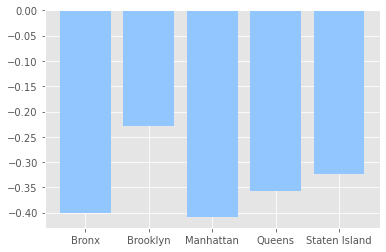

In [ ]:
bar_x_positions = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
plt.bar(bar_x_positions, axis_y)